In [1]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

from scipy.stats import pearsonr

def iso_normalizer(t) :
    iso = 0.0
    if np.sum(t) > 0.0 :
        iso = t[0] / np.sum(t)
    
    return iso

def cut_normalizer(t) :
    cuts = np.concatenate([np.zeros(100), np.array([1.0])])
    if np.sum(t) > 0.0 :
        cuts = t / np.sum(t)
    
    return cuts

#Logistic regression prediction
def get_y_pred(X, w, w_0) :
    return 1. / (1. + np.exp(-1. * (X.dot(w) + w_0)))

#Safe log for NLL
def safe_log(x, minval=0.01):
    return np.log(x.clip(min=minval))

def get_lr_single_region_predictor(nmer_df) :
    
    seq_start_1 = 10#147
    seq_start_2 = 10 + 25 + 18#147 + 25 + 18
    
    #Load LR weights
    hek_w_0 = nmer_df.iloc[0]['hek']
    hek_w = np.array(nmer_df.iloc[1:]['hek'].values)

    hela_w_0 = nmer_df.iloc[0]['hela']
    hela_w = np.array(nmer_df.iloc[1:]['hela'].values)

    mcf7_w_0 = nmer_df.iloc[0]['mcf7']
    mcf7_w = np.array(nmer_df.iloc[1:]['mcf7'].values)

    cho_w_0 = nmer_df.iloc[0]['cho']
    cho_w = np.array(nmer_df.iloc[1:]['cho'].values)
    
    encoder = iso.NMerEncoder(n_mer_len=6, count_n_mers=True)
    batch_encoder = iso.SparseBatchEncoder(encoder=encoder)
    
    def predictor(sequences) :
        
        region_up = [seq[seq_start_1 - 6 + 1: seq_start_1 + 25 + 6 - 1] for seq in sequences]
        #region_dn = [seq[seq_start_2 - 6 + 1: seq_start_2 + 25 + 6 - 1] for seq in sequences]
        
        X_up = batch_encoder(region_up)
        #X_dn = batch_encoder(region_dn)
        
        X = X_up#sp.hstack([X_up, X_dn])
        
        y_hek_test_pred = get_y_pred(X, hek_w, hek_w_0)
        y_hela_test_pred = get_y_pred(X, hela_w, hela_w_0)
        y_mcf7_test_pred = get_y_pred(X, mcf7_w, mcf7_w_0)
        y_cho_test_pred = get_y_pred(X, cho_w, cho_w_0)
        
        y_preds = [
            np.ravel(y_hek_test_pred),
            np.ravel(y_hela_test_pred),
            np.ravel(y_mcf7_test_pred),
            np.ravel(y_cho_test_pred)
        ]
        
        return y_preds
    
    return predictor

def get_lr_both_regions_predictor(nmer_df_region_1, nmer_df_region_2) :
    
    seq_start_1 = 10#147
    seq_start_2 = 10 + 25 + 18#147 + 25 + 18
    
    #Load LR weights
    hek_w_0_both_regions = nmer_df_region_1.iloc[0]['hek']
    hek_w_both_regions = np.concatenate([np.array(nmer_df_region_1.iloc[1:]['hek'].values), np.array(nmer_df_region_2['hek'].values)])

    hela_w_0_both_regions = nmer_df_region_1.iloc[0]['hela']
    hela_w_both_regions = np.concatenate([np.array(nmer_df_region_1.iloc[1:]['hela'].values), np.array(nmer_df_region_2['hela'].values)])

    mcf7_w_0_both_regions = nmer_df_region_1.iloc[0]['mcf7']
    mcf7_w_both_regions = np.concatenate([np.array(nmer_df_region_1.iloc[1:]['mcf7'].values), np.array(nmer_df_region_2['mcf7'].values)])

    cho_w_0_both_regions = nmer_df_region_1.iloc[0]['cho']
    cho_w_both_regions = np.concatenate([np.array(nmer_df_region_1.iloc[1:]['cho'].values), np.array(nmer_df_region_2['cho'].values)])

    encoder = iso.NMerEncoder(n_mer_len=6, count_n_mers=True)
    batch_encoder = iso.SparseBatchEncoder(encoder=encoder)
    
    def predictor(sequences) :
        
        region_up = [seq[seq_start_1 - 6 + 1: seq_start_1 + 25 + 6 - 1] for seq in sequences]
        region_dn = [seq[seq_start_2 - 6 + 1: seq_start_2 + 25 + 6 - 1] for seq in sequences]
        
        X_up = batch_encoder(region_up)
        X_dn = batch_encoder(region_dn)
        
        X = sp.hstack([X_up, X_dn])
        
        y_hek_test_pred = get_y_pred(X, hek_w_both_regions, hek_w_0_both_regions)
        y_hela_test_pred = get_y_pred(X, hela_w_both_regions, hela_w_0_both_regions)
        y_mcf7_test_pred = get_y_pred(X, mcf7_w_both_regions, mcf7_w_0_both_regions)
        y_cho_test_pred = get_y_pred(X, cho_w_both_regions, cho_w_0_both_regions)
        
        y_preds = [
            np.ravel(y_hek_test_pred),
            np.ravel(y_hela_test_pred),
            np.ravel(y_mcf7_test_pred),
            np.ravel(y_cho_test_pred)
        ]
        
        return y_preds
    
    return predictor

def get_cnn_predictor_only_random_regions(model) :
    
    seq_start_1 = 10#147
    seq_start_2 = 10 + 25 + 18#147 + 25 + 18
    
    encoder = iso.OneHotEncoder(seq_length=25 + 2 * 5)
    batch_encoder = iso.BatchEncoder(encoder=encoder)
    
    def predictor(sequences) :
        
        region_1 = [seq[seq_start_1 - 5: seq_start_1 + 25 + 5] for seq in sequences]
        region_2 = [seq[seq_start_2 - 5: seq_start_2 + 25 + 5] for seq in sequences]
        
        X_up = batch_encoder(region_1)
        X_dn = batch_encoder(region_2)
        
        predictions = model.predict(x=[X_up, X_dn])
        
        if predictions[0].shape[1] == 1 :
            predictions = [
                np.ravel(predictions[0]),
                np.ravel(predictions[1]),
                np.ravel(predictions[2]),
                np.ravel(predictions[3])
            ]
        else :
            predictions = [
                [np.ravel(predictions[0][i, :]) for i in range(predictions[0].shape[0])],
                [np.ravel(predictions[1][i, :]) for i in range(predictions[1].shape[0])],
                [np.ravel(predictions[2][i, :]) for i in range(predictions[2].shape[0])],
                [np.ravel(predictions[3][i, :]) for i in range(predictions[3].shape[0])],
            ]
        
        return predictions
    
    return predictor

def get_cnn_predictor(model) :
    
    seq_start_1 = 10#147
    seq_start_2 = 10 + 25 + 18#147 + 25 + 18
    
    encoder = iso.OneHotEncoder(seq_length=(seq_start_2 + 25 - seq_start_1) + 2 * 5)
    batch_encoder = iso.BatchEncoder(encoder=encoder)
    
    def predictor(sequences) :
        
        region_1 = [seq[seq_start_1 - 5: seq_start_2 + 25 + 5] for seq in sequences]
        X = batch_encoder(region_1)
        
        predictions = model.predict(x=[X])
        
        if predictions[0].shape[1] == 1 :
            predictions = [
                np.ravel(predictions[0]),
                np.ravel(predictions[1]),
                np.ravel(predictions[2]),
                np.ravel(predictions[3])
            ]
        else :
            predictions = [
                [np.ravel(predictions[0][i, :]) for i in range(predictions[0].shape[0])],
                [np.ravel(predictions[1][i, :]) for i in range(predictions[1].shape[0])],
                [np.ravel(predictions[2][i, :]) for i in range(predictions[2].shape[0])],
                [np.ravel(predictions[3][i, :]) for i in range(predictions[3].shape[0])],
            ]
        
        return predictions
    
    return predictor

def eval_df_sequence(seq_ix, predictors, pred_dfs) :
    
    print("Sequence = " + str(pred_dfs['lr_single_region'].iloc[seq_ix]['seq']))
    print("Generator = " + str(pred_dfs['lr_single_region'].iloc[seq_ix]['origin']))

    f = plt.figure(figsize=(10, 4))

    predictor_names = [predictor_name for predictor_name in predictors if "_cut" not in predictor_name]

    hek_preds = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hek'] for predictor_name in predictors if "_cut" not in predictor_name])
    hela_preds = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hela'] for predictor_name in predictors if "_cut" not in predictor_name])
    mcf7_preds = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_mcf7'] for predictor_name in predictors if "_cut" not in predictor_name])
    cho_preds = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_cho'] for predictor_name in predictors if "_cut" not in predictor_name])

    predictor_names_from_cuts = [predictor_name for predictor_name in predictors if "_cut" in predictor_name]

    hek_preds_from_cuts = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hek'][0] for predictor_name in predictors if "_cut" in predictor_name])
    hela_preds_from_cuts = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hela'][0] for predictor_name in predictors if "_cut" in predictor_name])
    mcf7_preds_from_cuts = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_mcf7'][0] for predictor_name in predictors if "_cut" in predictor_name])
    cho_preds_from_cuts = np.array([pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_cho'][0] for predictor_name in predictors if "_cut" in predictor_name])

    predictor_names.extend(predictor_names_from_cuts)

    hek_preds = np.concatenate([hek_preds, hek_preds_from_cuts], axis=0)
    hela_preds = np.concatenate([hela_preds, hela_preds_from_cuts], axis=0)
    mcf7_preds = np.concatenate([mcf7_preds, mcf7_preds_from_cuts], axis=0)
    cho_preds = np.concatenate([cho_preds, cho_preds_from_cuts], axis=0)


    predictor_ixs = np.arange(len(predictor_names))

    b_hek = plt.bar(predictor_ixs * 5, hek_preds, edgecolor='black', linewidth=2, label='HEK')
    plt.bar(predictor_ixs * 5 + 1, hela_preds, edgecolor='black', linewidth=2, label='HELA')
    plt.bar(predictor_ixs * 5 + 2, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
    plt.bar(predictor_ixs * 5 + 3, cho_preds, edgecolor='black', linewidth=2, label='CHO')

    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Pred SD1 Usage %", fontsize=14)

    plt.xticks(predictor_ixs * 5 + 1.5, [predictor_name.replace("_", "\n") for predictor_name in predictor_names], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

    plt.xlim(-1.5, len(predictor_ixs) * 5 - 0.5)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


    predictor_names = [predictor_name for predictor_name in predictors if "_cut" in predictor_name]

    hek_cut_preds = [pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hek'] for predictor_name in predictors if "_cut" in predictor_name]
    hela_cut_preds = [pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_hela'] for predictor_name in predictors if "_cut" in predictor_name]
    mcf7_cut_preds = [pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_mcf7'] for predictor_name in predictors if "_cut" in predictor_name]
    cho_cut_preds = [pred_dfs[predictor_name].iloc[seq_ix][predictor_name + '_cho'] for predictor_name in predictors if "_cut" in predictor_name]

    predictor_ixs = np.arange(len(predictor_names))

    cut_ixs = np.arange(101)

    for predictor_ix in predictor_ixs :

        f = plt.figure(figsize=(8, 3))

        predictor_name = predictor_names[predictor_ix]

        print("Cut Predictor = " + str(predictor_name))

        hek_cut_pred = hek_cut_preds[predictor_ix]
        hela_cut_pred = hela_cut_preds[predictor_ix]
        mcf7_cut_pred = mcf7_cut_preds[predictor_ix]
        cho_cut_pred = cho_cut_preds[predictor_ix]

        l_hek, = plt.plot(cut_ixs, hek_cut_pred, linewidth=2, label="HEK")
        l_hela, = plt.plot(cut_ixs, hela_cut_pred, linewidth=2, label="HELA")
        l_mcf7, = plt.plot(cut_ixs, mcf7_cut_pred, linewidth=2, label="MCF7")
        l_cho, = plt.plot(cut_ixs, cho_cut_pred, linewidth=2, label="CHO")

        plt.xlabel("Splice Position", fontsize=14)
        plt.ylabel("Pred Splice %", fontsize=14)

        plt.xticks([0, 44, 79, 100], ["SD1", "SD2", "SD3", "No Splice"], fontsize=14)
        plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

        plt.legend(handles=[l_hek, l_hela, l_mcf7, l_cho], fontsize=14)

        plt.tight_layout()

        plt.show()


Using TensorFlow backend.


In [2]:

#LR - Single region sequences
seqs_lr_single_region = [
    'AGGTGCTTGGGCATGCATGCATGCATGCATGCATGGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGATGTTGCATGCTATGCATGTGGCGGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGCGGCATGCATGCATGTTGCATGCGGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGATGCATGTTGCATGCTATGCATGGGGTCGACCCAGGTTCGTGNNNNNNNNNNNNNNNNNNNNNNNNNGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

#LR - Double region sequences
seqs_lr_both_regions = [
    'AGGTGCTTGGGCCGAACCTGGTCAAAAACCTGGTCGGTCGACCCAGGTTCGTGCTCCGGACCGACCTGGTCCTGAAAGGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGACCTGGTCGGTCCTGGTCGCCTGGGGTCGACCCAGGTTCGTGGCCGACCGACCTGGTACGGCCGACCGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGACCTGGTCCTGGTCCTGGTCGCCTGGTCGACCCAGGTTCGTGGAGCCGACCTGCGGACCGACCGACCGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGTGGTCCTGGTCAAACCTGGTCACCTGGTCGACCCAGGTTCGTGGAGCCGGCGGACCGACCTCCGGACCGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

#CNN - Double region sequences
seqs_cnn_both_regions = [
    'AGGTGCTTGGGCTGGGACGGAGGAAAGGGGATGGCGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGAATGGCAGGGGATGGCAAAAATGGGGTCGACCCAGGTTCGTGTCGACGTCGAAGCAGCATCGACGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGGGAATTAGAATGGATGGAAGGGATGGTCGACCCAGGTTCGTGGCGGACCGCCGGACACCGCCGGATCGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGAAGGGAAGGCTGGAAGGGGATGGCGGTCGACCCAGGTTCGTGCCGAAGCAGCGACGACGAAGTCATCGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

#CNN + LR - Double region sequences
seqs_cnn_lr_both_regions = [
    'AGGTGCTTGGGTGGAGGAAAATGGGTGGAGGAAATGGTCGACCCAGGTTCGTGGCGCCTCGCCGAAGCTGCAACGCAAGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGAGGAAAGGAGAGGGCGGAAACCGGGGTCGACCCAGGTTCGTGTCGACGACCTGCATCGCTGAAGGAAGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGAATGGGCGGAAACTTGAGAGGGCTGGTCGACCCAGGTTCGTGCCGAAGAAGCTGCCGTCGCCGCGAAGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGACTAGTGGTGGTGGATGGTTGGCTGGTCGACCCAGGTTCGTGCTGAAGCAGCTGCTCGCCGAAGGAAGAGGTATTCTTATCACCTTCGTGGCTACAGA'
]

#CNN GCATGC - Double region sequences
seqs_cnn_both_regions_gcatgc = [
    'AGGTGCTTGGGCATGCATGCATGCATGCATGCATGGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGGATGCATGTTGCATGCTATGCATGGGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGCATGCCCCTTGTTTTTTGCATGCATGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
    'AGGTGCTTGGCCCCTTGTTTTTTTTGCATGCATGCGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA',
]

gen_df = pd.DataFrame({
    'seq' : seqs_lr_single_region + seqs_lr_both_regions + seqs_cnn_both_regions + seqs_cnn_lr_both_regions + seqs_cnn_both_regions_gcatgc,
    'origin' : (['lr_single_region'] * 4) + (['lr_both_regions'] * 4) + (['cnn_both_regions'] * 4) + (['cnn_lr_both_regions'] * 4) + (['cnn_both_regions_gcatgc'] * 4)
})

gen_df = gen_df[['seq', 'origin']]

print(gen_df.head())


                                                 seq            origin
0  AGGTGCTTGGGCATGCATGCATGCATGCATGCATGGGTCGACCCAG...  lr_single_region
1  AGGTGCTTGGGATGTTGCATGCTATGCATGTGGCGGGTCGACCCAG...  lr_single_region
2  AGGTGCTTGGGCGGCATGCATGCATGTTGCATGCGGGTCGACCCAG...  lr_single_region
3  AGGTGCTTGGGATGCATGTTGCATGCTATGCATGGGGTCGACCCAG...  lr_single_region
4  AGGTGCTTGGGCCGAACCTGGTCAAAAACCTGGTCGGTCGACCCAG...   lr_both_regions


In [3]:
#Load LR models

#Single region model predictions
nmer_df = pd.read_csv('../logistic_regression/alt_5ss_6mers.csv', sep='\t')

lr_single_region = get_lr_single_region_predictor(nmer_df)


#Both region model predictions
nmer_df_region_1 = pd.read_csv('../logistic_regression/alt_5ss_6mers_both_regions_1.csv', sep='\t')
nmer_df_region_2 = pd.read_csv('../logistic_regression/alt_5ss_6mers_both_regions_2.csv', sep='\t')

lr_both_regions = get_lr_both_regions_predictor(nmer_df_region_1, nmer_df_region_2)

#Load CNN models

save_dir_path = '../saved_models'

model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_drop_02_sgd' + '.h5')
cnn_only_random_regions = get_cnn_predictor_only_random_regions(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_cuts_drop_02_sgd' + '.h5')
cnn_only_random_regions_cuts = get_cnn_predictor_only_random_regions(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_drop_02_sgd' + '.h5')
cnn = get_cnn_predictor(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_cuts_drop_02_sgd' + '.h5')
cnn_cuts = get_cnn_predictor(load_model(model_path))


model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_drop_02_sgd_targeted_a5ss' + '.h5')
cnn_only_random_regions_targeted_a5ss = get_cnn_predictor_only_random_regions(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_cuts_drop_02_sgd_targeted_a5ss' + '.h5')
cnn_only_random_regions_cuts_targeted_a5ss = get_cnn_predictor_only_random_regions(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_drop_02_sgd_targeted_a5ss' + '.h5')
cnn_targeted_a5ss = get_cnn_predictor(load_model(model_path))

model_path = os.path.join(save_dir_path, 'aparent_splirent_cuts_drop_02_sgd_targeted_a5ss' + '.h5')
cnn_cuts_targeted_a5ss = get_cnn_predictor(load_model(model_path))

predictors = {
    'lr_single_region' : lr_single_region,
    'lr_both_regions' : lr_both_regions,
    'cnn_only_random_regions' : cnn_only_random_regions,
    'cnn_only_random_regions_cuts' : cnn_only_random_regions_cuts,
    'cnn' : cnn,
    'cnn_cuts' : cnn_cuts,
    'cnn_only_random_regions_targeted_a5ss' : cnn_only_random_regions_targeted_a5ss,
    'cnn_only_random_regions_cuts_targeted_a5ss' : cnn_only_random_regions_cuts_targeted_a5ss,
    'cnn_targeted_a5ss' : cnn_targeted_a5ss,
    'cnn_cuts_targeted_a5ss' : cnn_cuts_targeted_a5ss,
}



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:

pred_dfs = {}

#Make predictions with all models over generated data
for predictor_name in predictors :
    preds_hek, preds_hela, preds_mcf7, preds_cho = predictors[predictor_name](list(gen_df['seq'].values))
    
    pred_df = pd.DataFrame({
        'seq' : list(gen_df['seq'].values),
        'origin' : list(gen_df['origin'].values),
        predictor_name + '_hek' : preds_hek,
        predictor_name + '_hela' : preds_hela,
        predictor_name + '_mcf7' : preds_mcf7,
        predictor_name + '_cho' : preds_cho,
    })

    pred_df = pred_df[['seq', 'origin', predictor_name + '_hek', predictor_name + '_hela', predictor_name + '_mcf7', predictor_name + '_cho']]

    pred_dfs[predictor_name] = pred_df
    

Sequence = AGGTGCTTGGGCTGGGACGGAGGAAAGGGGATGGCGGTCGACCCAGGTTCGTGCCGGATCACCGACGAAGAAGCCGACGAGGTATTCTTATCACCTTCGTGGCTACAGA
Generator = cnn_both_regions


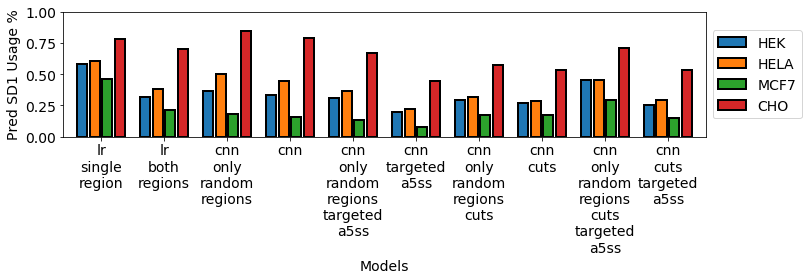

Cut Predictor = cnn_only_random_regions_cuts


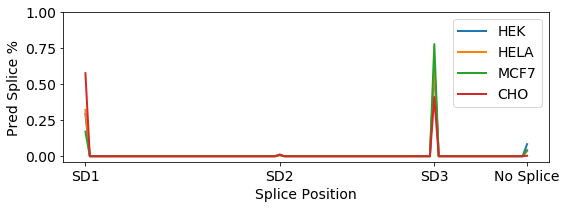

Cut Predictor = cnn_cuts


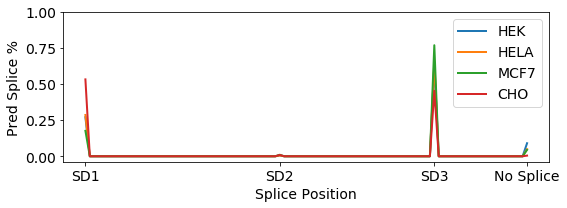

Cut Predictor = cnn_only_random_regions_cuts_targeted_a5ss


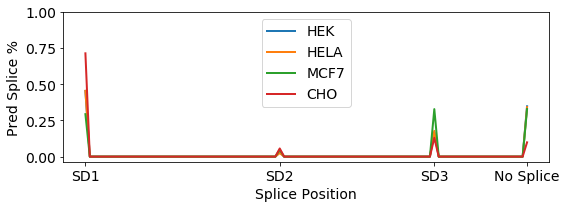

Cut Predictor = cnn_cuts_targeted_a5ss


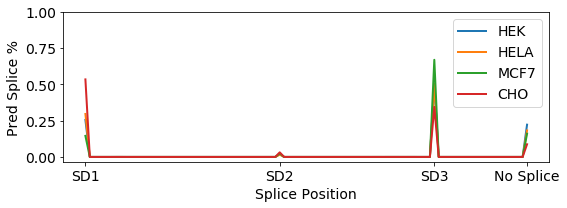

--------------------------------------------------------------
Sequence = AGGTGCTTGGGGGAATTAGAATGGATGGAAGGGATGGTCGACCCAGGTTCGTGGCGGACCGCCGGACACCGCCGGATCGAGGTATTCTTATCACCTTCGTGGCTACAGA
Generator = cnn_both_regions


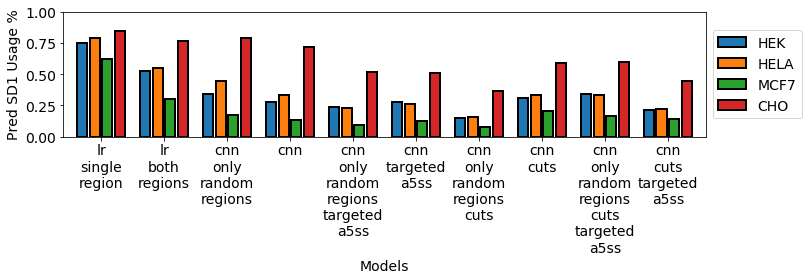

Cut Predictor = cnn_only_random_regions_cuts


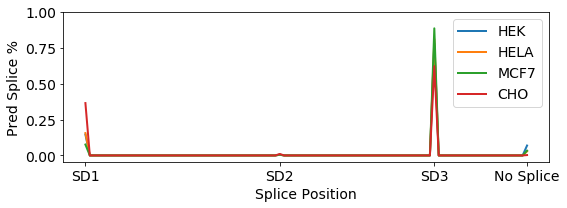

Cut Predictor = cnn_cuts


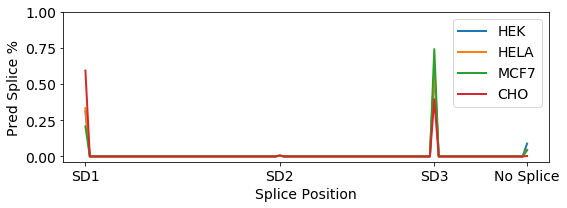

Cut Predictor = cnn_only_random_regions_cuts_targeted_a5ss


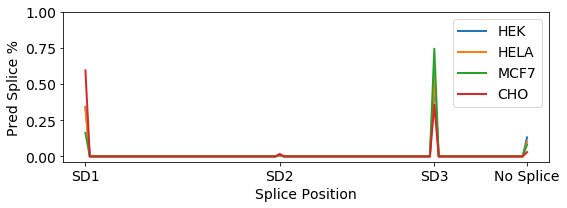

Cut Predictor = cnn_cuts_targeted_a5ss


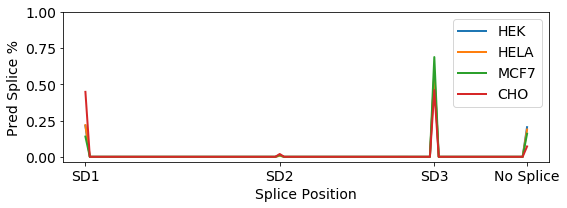

--------------------------------------------------------------
Sequence = AGGTGCTTGGGAATGGGCGGAAACTTGAGAGGGCTGGTCGACCCAGGTTCGTGCCGAAGAAGCTGCCGTCGCCGCGAAGAGGTATTCTTATCACCTTCGTGGCTACAGA
Generator = cnn_lr_both_regions


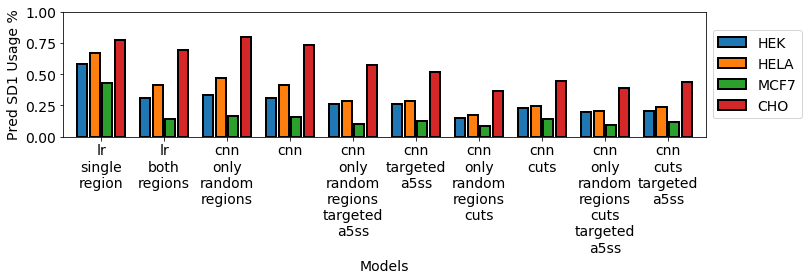

Cut Predictor = cnn_only_random_regions_cuts


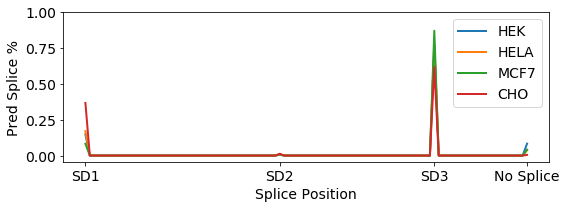

Cut Predictor = cnn_cuts


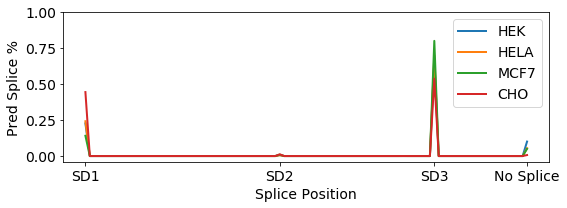

Cut Predictor = cnn_only_random_regions_cuts_targeted_a5ss


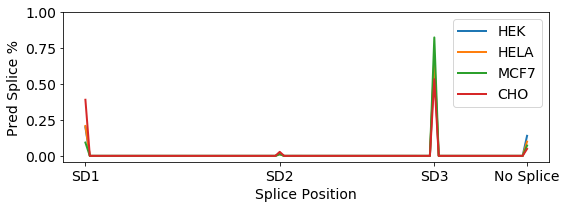

Cut Predictor = cnn_cuts_targeted_a5ss


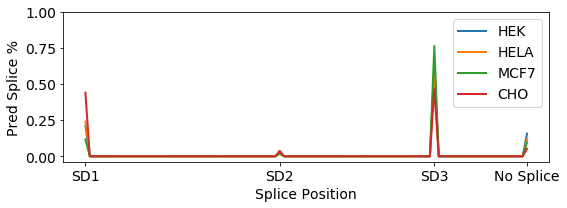

--------------------------------------------------------------
Sequence = AGGTGCTTGGGTGGAGGAAAATGGGTGGAGGAAATGGTCGACCCAGGTTCGTGGCGCCTCGCCGAAGCTGCAACGCAAGAGGTATTCTTATCACCTTCGTGGCTACAGA
Generator = cnn_lr_both_regions


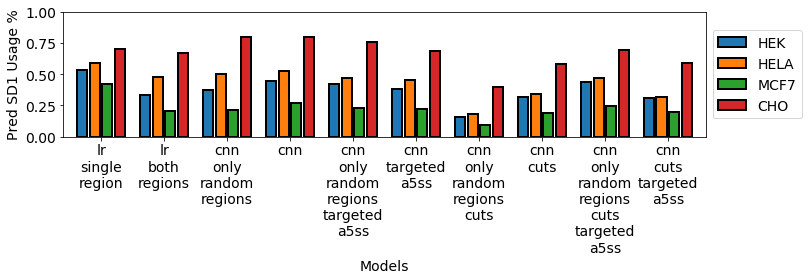

Cut Predictor = cnn_only_random_regions_cuts


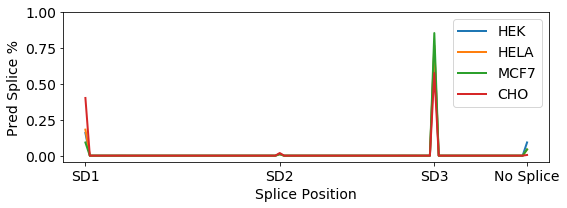

Cut Predictor = cnn_cuts


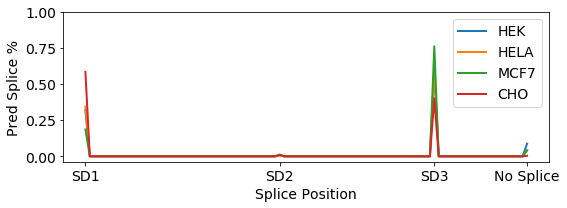

Cut Predictor = cnn_only_random_regions_cuts_targeted_a5ss


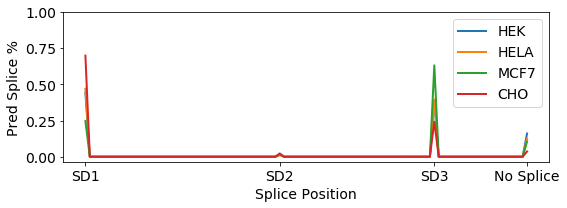

Cut Predictor = cnn_cuts_targeted_a5ss


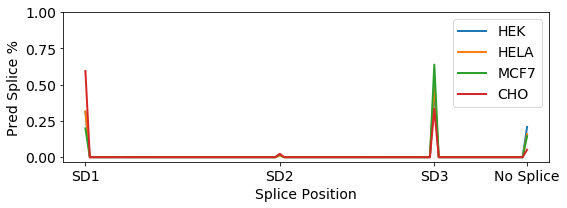

--------------------------------------------------------------
Sequence = AGGTGCTTGGGAAGGGAAGGCTGGAAGGGGATGGCGGTCGACCCAGGTTCGTGCCGAAGCAGCGACGACGAAGTCATCGAGGTATTCTTATCACCTTCGTGGCTACAGA
Generator = cnn_both_regions


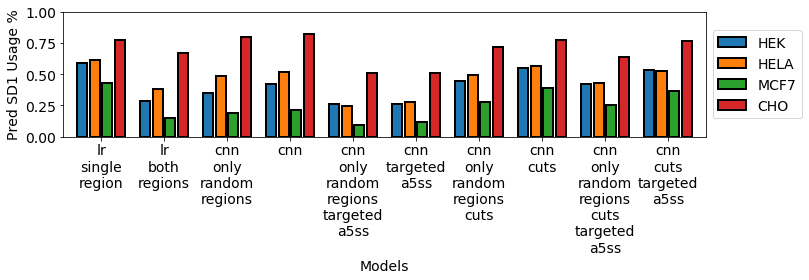

Cut Predictor = cnn_only_random_regions_cuts


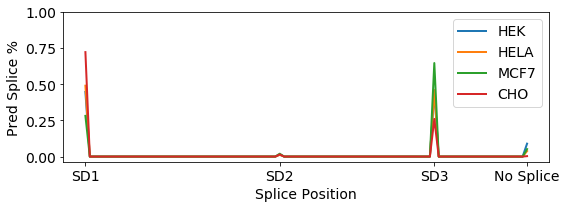

Cut Predictor = cnn_cuts


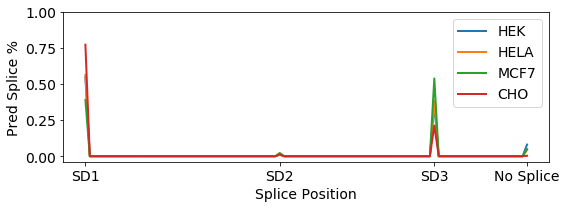

Cut Predictor = cnn_only_random_regions_cuts_targeted_a5ss


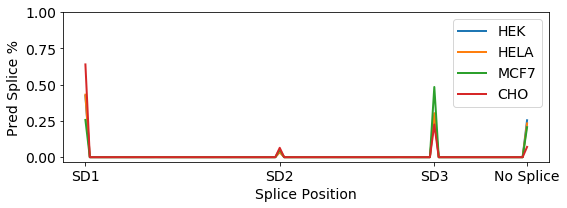

Cut Predictor = cnn_cuts_targeted_a5ss


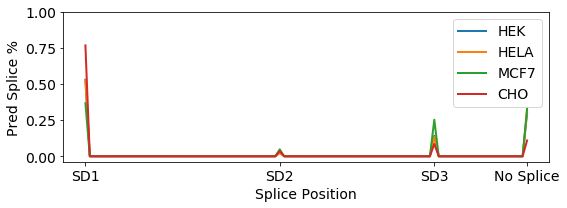

--------------------------------------------------------------


In [5]:

#Evaluate experimental sequences and display predictions

for seq_ix in [8, 10, 14, 12, 11] :
    eval_df_sequence(seq_ix, predictors, pred_dfs)
    
    print("--------------------------------------------------------------")


In [6]:
import pickle

#Create nearest neighbor search database

#Load plasmid data
plasmid_dict = pickle.load(open('../data/a5ss/processed_data/' + 'alt_5ss_data.pickle', 'rb'))

valid_set_size = 10000
test_set_size = 10000

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)

if valid_set_size < 1.0 and test_set_size < 1.0 :
    train_index = plasmid_index[:-int(len(plasmid_dict['min_df']) * (valid_set_size + test_set_size))]
    valid_index = plasmid_index[train_index.shape[0]:-int(len(plasmid_dict['min_df']) * test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]
else :
    train_index = plasmid_index[:-int(valid_set_size + test_set_size)]
    valid_index = plasmid_index[train_index.shape[0]:-int(test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

sequence_padding = 0

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_count' : plasmid_dict['min_hek_count'],
            'hela_count' : plasmid_dict['min_hela_count'],
            'mcf7_count' : plasmid_dict['min_mcf7_count'],
            'cho_count' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),#32,
        inputs = [
            {
                'id' : 'full_sequence',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_1 - sequence_padding: seq_start_1 + 25 + sequence_padding] + row['padded_seq'][seq_start_2 - sequence_padding: seq_start_2 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=50 + 2 * sequence_padding),
                'dim' : (50 + 2 * sequence_padding, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: iso_normalizer(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ] + [
            {
                'id' : cell_type + '_count',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: np.sum(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=False,
    ) for gen_id, idx in [('all', plasmid_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 244647
Validation set size = 10000
Test set size = 10000


In [7]:

[onehots], [hek_true, hela_true, mcf7_true, cho_true, hek_count, hela_count, mcf7_count, cho_count] = splicing_gens['all'][0]


In [8]:

#Filter dataset

keep_index = np.nonzero((mcf7_count >= 30) & (cho_count >= 30))[0]

onehots_kept = onehots[keep_index]

hek_true_kept = hek_true[keep_index]
hela_true_kept = hela_true[keep_index]
mcf7_true_kept = mcf7_true[keep_index]
cho_true_kept = cho_true[keep_index]

hek_count_kept = hek_count[keep_index]
hela_count_kept = hela_count[keep_index]
mcf7_count_kept = mcf7_count[keep_index]
cho_count_kept = cho_count[keep_index]


In [10]:

from sklearn.neighbors import KNeighborsRegressor

onehots_flat_kept = np.reshape(onehots_kept, (onehots_kept.shape[0], onehots_kept.shape[1] * onehots_kept.shape[2]))

nn_mcf7_50 = KNeighborsRegressor(n_neighbors=50).fit(onehots_flat_kept, mcf7_true_kept)
nn_cho_50 = KNeighborsRegressor(n_neighbors=50).fit(onehots_flat_kept, cho_true_kept)

nn_mcf7_10 = KNeighborsRegressor(n_neighbors=10).fit(onehots_flat_kept, mcf7_true_kept)
nn_cho_10 = KNeighborsRegressor(n_neighbors=10).fit(onehots_flat_kept, cho_true_kept)


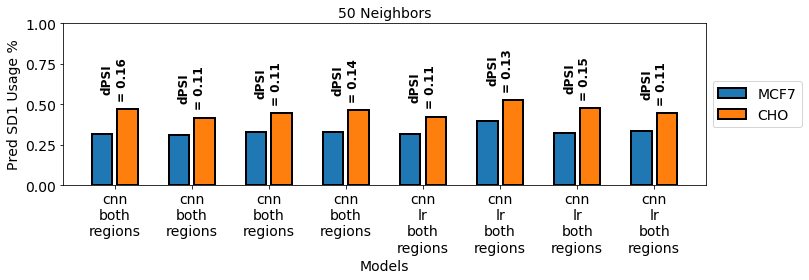

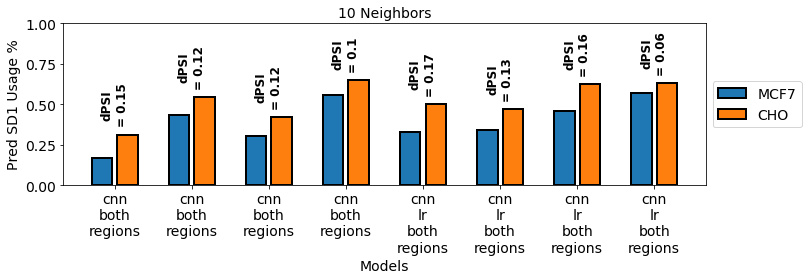

In [25]:

sel_df = gen_df.loc[gen_df['origin'].isin(['cnn_both_regions', 'cnn_lr_both_regions'])]

seq_start_1 = 10#147
seq_start_2 = 10 + 25 + 18#147 + 25 + 18

encoder = iso.OneHotEncoder(seq_length=50)
batch_encoder = iso.BatchEncoder(encoder=encoder)

extracted_regions = [row['seq'][seq_start_1: seq_start_1 + 25] + row['seq'][seq_start_2: seq_start_2 + 25] for _, row in sel_df.iterrows()]


gen_onehots = batch_encoder(extracted_regions)
gen_onehots_flat = np.reshape(gen_onehots, (gen_onehots.shape[0], gen_onehots.shape[1] * gen_onehots.shape[2]))


nn_mcf7_pred_50 = nn_mcf7_50.predict(gen_onehots_flat)
nn_cho_pred_50 = nn_cho_50.predict(gen_onehots_flat)

mcf7_preds = np.ravel(nn_mcf7_pred_50)
cho_preds = np.ravel(nn_cho_pred_50)

f = plt.figure(figsize=(10, 4))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.05, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("50 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()




nn_mcf7_pred_10 = nn_mcf7_10.predict(gen_onehots_flat)
nn_cho_pred_10 = nn_cho_10.predict(gen_onehots_flat)

mcf7_preds = np.ravel(nn_mcf7_pred_10)
cho_preds = np.ravel(nn_cho_pred_10)

f = plt.figure(figsize=(10, 4))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.05, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("10 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [26]:

onehots_flat_kept_up = onehots_flat_kept[:, :25 * 4]

nn_mcf7_up_50 = KNeighborsRegressor(n_neighbors=50).fit(onehots_flat_kept_up, mcf7_true_kept)
nn_cho_up_50 = KNeighborsRegressor(n_neighbors=50).fit(onehots_flat_kept_up, cho_true_kept)

nn_mcf7_up_10 = KNeighborsRegressor(n_neighbors=10).fit(onehots_flat_kept_up, mcf7_true_kept)
nn_cho_up_10 = KNeighborsRegressor(n_neighbors=10).fit(onehots_flat_kept_up, cho_true_kept)


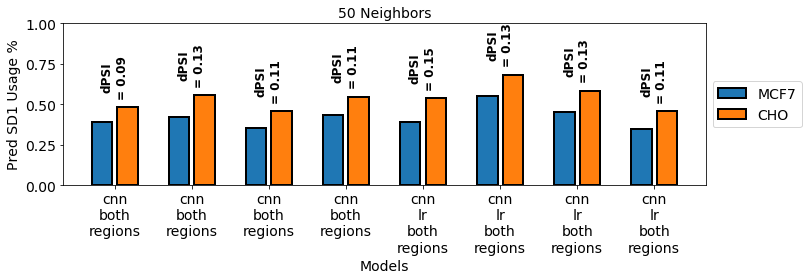

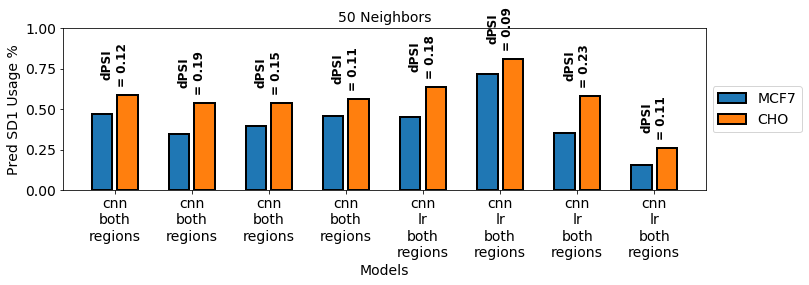

In [27]:

sel_df = gen_df.loc[gen_df['origin'].isin(['cnn_both_regions', 'cnn_lr_both_regions'])]

seq_start_1 = 10#147
seq_start_2 = 10 + 25 + 18#147 + 25 + 18

encoder = iso.OneHotEncoder(seq_length=25)
batch_encoder = iso.BatchEncoder(encoder=encoder)

extracted_regions_up = [row['seq'][seq_start_1: seq_start_1 + 25] for _, row in sel_df.iterrows()]

gen_onehots_up = batch_encoder(extracted_regions_up)

gen_onehots_flat_up = np.reshape(gen_onehots_up, (gen_onehots_up.shape[0], gen_onehots_up.shape[1] * gen_onehots_up.shape[2]))


nn_mcf7_pred_up_50 = nn_mcf7_up_50.predict(gen_onehots_flat_up)
nn_cho_pred_up_50 = nn_cho_up_50.predict(gen_onehots_flat_up)

mcf7_preds = np.ravel(nn_mcf7_pred_up_50)
cho_preds = np.ravel(nn_cho_pred_up_50)

f = plt.figure(figsize=(10, 4))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.05, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("50 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


nn_mcf7_pred_up_10 = nn_mcf7_up_10.predict(gen_onehots_flat_up)
nn_cho_pred_up_10 = nn_cho_up_10.predict(gen_onehots_flat_up)

mcf7_preds = np.ravel(nn_mcf7_pred_up_10)
cho_preds = np.ravel(nn_cho_pred_up_10)

f = plt.figure(figsize=(10, 4))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.05, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("10 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [28]:

model_path = os.path.join(save_dir_path, 'aparent_splirent_only_random_regions_drop_02_sgd' + '.h5')
splicing_model = load_model(model_path)


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [29]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion

dense_out_model = Model(
    inputs = splicing_model.inputs,
    outputs = [
        splicing_model.get_layer('dropout_1').output
    ]
)


In [30]:
import pickle

#Create nearest neighbor search database

#Load plasmid data
plasmid_dict = pickle.load(open('../data/a5ss/processed_data/' + 'alt_5ss_data.pickle', 'rb'))

valid_set_size = 10000
test_set_size = 10000

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_dict['min_df']), dtype=np.int)

if valid_set_size < 1.0 and test_set_size < 1.0 :
    train_index = plasmid_index[:-int(len(plasmid_dict['min_df']) * (valid_set_size + test_set_size))]
    valid_index = plasmid_index[train_index.shape[0]:-int(len(plasmid_dict['min_df']) * test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]
else :
    train_index = plasmid_index[:-int(valid_set_size + test_set_size)]
    valid_index = plasmid_index[train_index.shape[0]:-int(test_set_size)]
    test_index = plasmid_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


seq_start_1 = 147
seq_start_2 = 147 + 25 + 18
splice_donor_pos = 140

sequence_padding = 5

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : plasmid_dict['min_df'],
            'hek_count' : plasmid_dict['min_hek_count'],
            'hela_count' : plasmid_dict['min_hela_count'],
            'mcf7_count' : plasmid_dict['min_mcf7_count'],
            'cho_count' : plasmid_dict['min_cho_count'],
        },
        batch_size=len(idx),#32,
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_1 - sequence_padding: seq_start_1 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            },
            {
                'id' : 'random_region_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, seq_start_1=seq_start_1, seq_start_2=seq_start_2, sequence_padding=sequence_padding: row['padded_seq'][seq_start_2 - sequence_padding: seq_start_2 + 25 + sequence_padding],
                'encoder' : iso.OneHotEncoder(seq_length=25 + 2 * sequence_padding),
                'dim' : (25 + 2 * sequence_padding, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : cell_type + '_sd1_usage',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: iso_normalizer(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ] + [
            {
                'id' : cell_type + '_count',
                'source_type' : 'matrix',
                'source' : cell_type + '_count',
                'extractor' : iso.CountExtractor(start_pos=splice_donor_pos, end_pos=splice_donor_pos + 100, static_poses=[-1], sparse_source=True),
                'transformer' : lambda t: np.sum(t),
                'dim' : (1,)
            } for cell_type in ['hek', 'hela', 'mcf7', 'cho']
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=False,
    ) for gen_id, idx in [('all', plasmid_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 244647
Validation set size = 10000
Test set size = 10000


In [31]:

[onehots_up, onehots_dn], [hek_true, hela_true, mcf7_true, cho_true, hek_count, hela_count, mcf7_count, cho_count] = splicing_gens['all'][0]


In [32]:

#Filter dataset

keep_index = np.nonzero((mcf7_count >= 30) & (cho_count >= 30))[0]

onehots_up_kept = onehots_up[keep_index]
onehots_dn_kept = onehots_dn[keep_index]

hek_true_kept = hek_true[keep_index]
hela_true_kept = hela_true[keep_index]
mcf7_true_kept = mcf7_true[keep_index]
cho_true_kept = cho_true[keep_index]

hek_count_kept = hek_count[keep_index]
hela_count_kept = hela_count[keep_index]
mcf7_count_kept = mcf7_count[keep_index]
cho_count_kept = cho_count[keep_index]


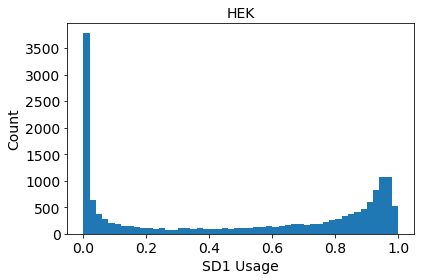

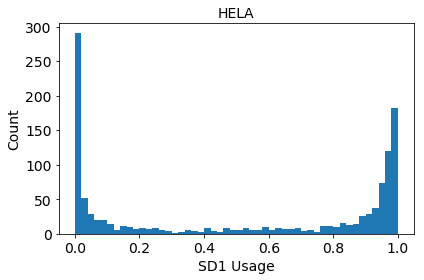

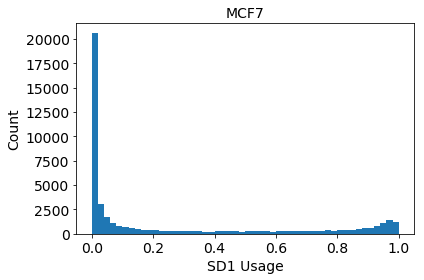

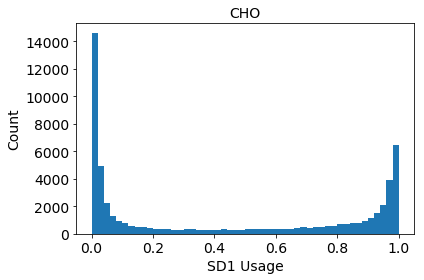

In [43]:

min_count = 100

sd_tuples = [
    ('HEK', hek_true_kept, hek_count_kept),
    ('HELA', hela_true_kept, hela_count_kept),
    ('MCF7', mcf7_true_kept, mcf7_count_kept),
    ('CHO', cho_true_kept, cho_count_kept)
]

for cell, sd1_true, total_c in sd_tuples :

    f = plt.figure(figsize=(6, 4))
    
    filter_index = np.nonzero(total_c >= min_count)[0]

    plt.hist(np.ravel(sd1_true[filter_index]), bins=50)

    plt.xlabel("SD1 Usage", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.title(cell, fontsize=14)

    plt.tight_layout()

    plt.show()


In [34]:

library_dense_out_kept = dense_out_model.predict(x=[onehots_up_kept, onehots_dn_kept], batch_size=32)

print(library_dense_out_kept.shape)


(201673, 256)


In [35]:

from sklearn.neighbors import KNeighborsRegressor

nn_dense_mcf7_50 = KNeighborsRegressor(n_neighbors=50).fit(library_dense_out_kept, mcf7_true_kept)
nn_dense_cho_50 = KNeighborsRegressor(n_neighbors=50).fit(library_dense_out_kept, cho_true_kept)

nn_dense_mcf7_10 = KNeighborsRegressor(n_neighbors=10).fit(library_dense_out_kept, mcf7_true_kept)
nn_dense_cho_10 = KNeighborsRegressor(n_neighbors=10).fit(library_dense_out_kept, cho_true_kept)


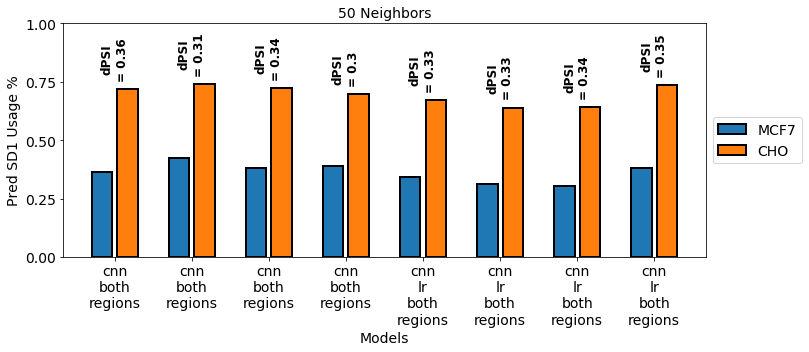

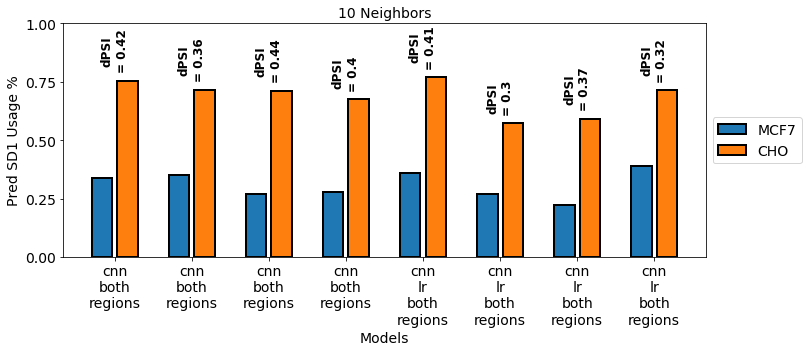

In [39]:

sel_df = gen_df.loc[gen_df['origin'].isin(['cnn_both_regions', 'cnn_lr_both_regions'])]

seq_start_1 = 10#147
seq_start_2 = 10 + 25 + 18#147 + 25 + 18

encoder = iso.OneHotEncoder(seq_length=25 + 2 * 5)

gen_extracted_onehots_1 = np.concatenate([np.reshape(encoder(row['seq'][seq_start_1 - 5: seq_start_1 + 25 + 5]), (1, 25 + 2 * 5, 4)) for _, row in sel_df.iterrows()])
gen_extracted_onehots_2 = np.concatenate([np.reshape(encoder(row['seq'][seq_start_2 - 5: seq_start_2 + 25 + 5]), (1, 25 + 2 * 5, 4)) for _, row in sel_df.iterrows()])

gen_dense_out = dense_out_model.predict(x=[gen_extracted_onehots_1, gen_extracted_onehots_2], batch_size=32)


nn_dense_mcf7_pred_50 = nn_dense_mcf7_50.predict(gen_dense_out)
nn_dense_cho_pred_50 = nn_dense_cho_50.predict(gen_dense_out)

mcf7_preds = np.ravel(nn_dense_mcf7_pred_50)
cho_preds = np.ravel(nn_dense_cho_pred_50)

f = plt.figure(figsize=(10, 5))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.035, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("50 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


nn_dense_mcf7_pred_10 = nn_dense_mcf7_10.predict(gen_dense_out)
nn_dense_cho_pred_10 = nn_dense_cho_10.predict(gen_dense_out)

mcf7_preds = np.ravel(nn_dense_mcf7_pred_10)
cho_preds = np.ravel(nn_dense_cho_pred_10)

f = plt.figure(figsize=(10, 5))

origin_names = [row['origin'] for _, row in sel_df.iterrows()]

data_ixs = np.arange(len(origin_names))

plt.bar(data_ixs * 3, mcf7_preds, edgecolor='black', linewidth=2, label='MCF7')
plt.bar(data_ixs * 3 + 1, cho_preds, edgecolor='black', linewidth=2, label='CHO')

for i in range(len(data_ixs)) :
    plt.text(i * 3 + 0.5, max(cho_preds[i], mcf7_preds[i]) + 0.035, "dPSI\n= " + str(round(cho_preds[i] - mcf7_preds[i], 2)), horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=12, weight='bold', rotation=90)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xlabel("Models", fontsize=14)
plt.ylabel("Pred SD1 Usage %", fontsize=14)
plt.title("10 Neighbors", fontsize=14)

plt.xticks(data_ixs * 3 + 0.5, [origin_name.replace("_", "\n") for origin_name in origin_names], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.xlim(-1.5, len(data_ixs) * 3 - 0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
